In [17]:
import numpy as np
import pandas as pd

# -------------------------------
# 1. BASIC SETTINGS
# -------------------------------
np.random.seed(42)

DURATION_MINUTES = 30
SAMPLING_RATE = 1  # 1 sample per second
TOTAL_SECONDS = DURATION_MINUTES * 60

time_sec = np.arange(TOTAL_SECONDS)

# -------------------------------
# 2. BASELINE (STABLE PATIENT)
# -------------------------------
heart_rate = np.random.normal(75, 2, TOTAL_SECONDS)
spo2 = np.random.normal(98, 0.3, TOTAL_SECONDS)
systolic_bp = np.random.normal(120, 3, TOTAL_SECONDS)
diastolic_bp = np.random.normal(80, 2, TOTAL_SECONDS)
motion = np.random.normal(0.05, 0.02, TOTAL_SECONDS)

# -------------------------------
# 3. PHASE 2: AMBULANCE MOTION (8–12 min)
# -------------------------------
start, end = 8*60, 12*60

motion[start:end] += np.random.normal(0.4, 0.1, end - start)
spo2[start:end] -= motion[start:end] * 6     # false SpO2 drops
heart_rate[start:end] += motion[start:end] * 8

# -------------------------------
# 4. PHASE 3: EARLY DISTRESS (12–18 min)
# -------------------------------
start, end = 12*60, 18*60

heart_rate[start:end] += np.linspace(0, 20, end - start)
spo2[start:end] -= np.linspace(0, 4, end - start)
systolic_bp[start:end] -= np.linspace(0, 8, end - start)

# -------------------------------
# 5. PHASE 4: CRITICAL DETERIORATION (18–22 min)
# -------------------------------
start, end = 18*60, 22*60

heart_rate[start:end] += 25
spo2[start:end] -= 8
systolic_bp[start:end] -= 20
diastolic_bp[start:end] -= 10

# -------------------------------
# 6. PHASE 5: INTERVENTION & RECOVERY (22–30 min)
# -------------------------------
start = 22*60

heart_rate[start:] -= np.linspace(0, 15, TOTAL_SECONDS - start)
spo2[start:] += np.linspace(0, 5, TOTAL_SECONDS - start)
systolic_bp[start:] += np.linspace(0, 10, TOTAL_SECONDS - start)

# -------------------------------
# 7. PHYSIOLOGICAL LIMITS
# -------------------------------
heart_rate = np.clip(heart_rate, 40, 180)
spo2 = np.clip(spo2, 80, 100)
systolic_bp = np.clip(systolic_bp, 70, 180)
diastolic_bp = np.clip(diastolic_bp, 40, 120)
motion = np.clip(motion, 0, None)

# -------------------------------
# 8. CREATE DATAFRAME
# -------------------------------
df = pd.DataFrame({
    "time_sec": time_sec,
    "heart_rate": heart_rate,
    "spo2": spo2,
    "systolic_bp": systolic_bp,
    "diastolic_bp": diastolic_bp,
    "motion": motion
})

# -------------------------------
# 9. SAVE DATA
# -------------------------------
df.to_csv("synthetic_ambulance_patient_data.csv", index=False)

print("✅ Synthetic ambulance data collected and saved successfully!")
print(df.head())


✅ Synthetic ambulance data collected and saved successfully!
   time_sec  heart_rate       spo2  systolic_bp  diastolic_bp    motion
0         0   75.993428  98.570357   117.528194     77.624470  0.052793
1         1   74.723471  97.981802   117.842672     79.205353  0.051300
2         2   76.295377  97.787478   126.149436     81.068730  0.066266
3         3   78.046060  97.545886   120.002048     80.182187  0.033123
4         4   74.531693  97.459058   122.346390     78.296920  0.015127


In [18]:
import os
print(os.getcwd())


C:\Users\malagha


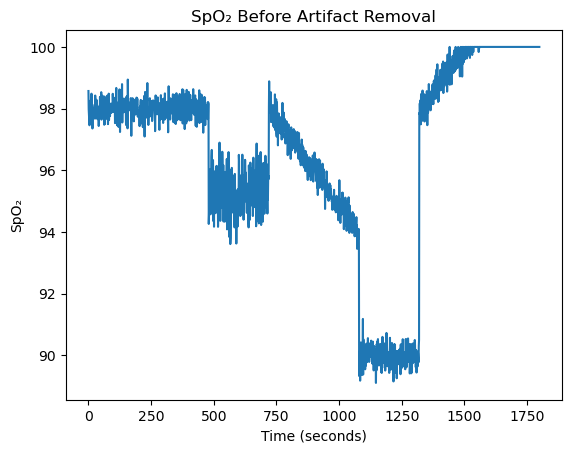

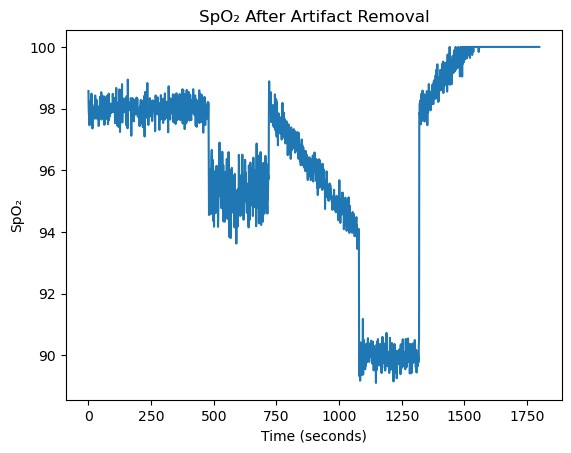

✅ Artifact detection completed
✅ Cleaned data saved as synthetic_ambulance_patient_data_cleaned.csv


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. LOAD DATA
# -------------------------------
df = pd.read_csv("synthetic_ambulance_patient_data.csv")

# -------------------------------
# 2. DETECT SpO2 ARTIFACTS
# -------------------------------
# Assumptions:
# - High motion causes false SpO2 drops
# - Sudden drops are more likely artifacts than slow trends

MOTION_THRESHOLD = 0.3
SPO2_DROP_THRESHOLD = -2  # sudden drop in one second

# Calculate change in SpO2
df["spo2_diff"] = df["spo2"].diff()

# Artifact condition
df["spo2_artifact"] = (
    (df["motion"] > MOTION_THRESHOLD) &
    (df["spo2_diff"] < SPO2_DROP_THRESHOLD)
)

# -------------------------------
# 3. ARTIFACT CORRECTION
# -------------------------------
# Use rolling median to smooth artifacts
df["spo2_clean"] = df["spo2"].copy()

rolling_median = df["spo2"].rolling(
    window=15,
    center=True
).median()

df.loc[df["spo2_artifact"], "spo2_clean"] = rolling_median[df["spo2_artifact"]]

# -------------------------------
# 4. BEFORE vs AFTER PLOTS
# -------------------------------
# Before cleaning
plt.figure()
plt.plot(df["time_sec"], df["spo2"])
plt.title("SpO₂ Before Artifact Removal")
plt.xlabel("Time (seconds)")
plt.ylabel("SpO₂")
plt.show()

# After cleaning
plt.figure()
plt.plot(df["time_sec"], df["spo2_clean"])
plt.title("SpO₂ After Artifact Removal")
plt.xlabel("Time (seconds)")
plt.ylabel("SpO₂")
plt.show()

# -------------------------------
# 5. SAVE CLEANED DATA
# -------------------------------
df.to_csv("synthetic_ambulance_patient_data_cleaned.csv", index=False)

print("✅ Artifact detection completed")
print("✅ Cleaned data saved as synthetic_ambulance_patient_data_cleaned.csv")


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. LOAD CLEANED DATA
# -------------------------------
df = pd.read_csv("synthetic_ambulance_patient_data_cleaned.csv")

# -------------------------------
# 2. ROLLING WINDOW FEATURES
# -------------------------------
WINDOW = 60  # 60 seconds

df["hr_mean"] = df["heart_rate"].rolling(WINDOW).mean()
df["spo2_mean"] = df["spo2_clean"].rolling(WINDOW).mean()
df["bp_mean"] = df["systolic_bp"].rolling(WINDOW).mean()

# -------------------------------
# 3. BASELINE (FIRST 5 MINUTES)
# -------------------------------
baseline = df.iloc[:5*60]

hr_base = baseline["hr_mean"].mean()
spo2_base = baseline["spo2_mean"].mean()
bp_base = baseline["bp_mean"].mean()

# -------------------------------
# 4. ANOMALY DETECTION LOGIC
# -------------------------------
df["anomaly"] = (
    (df["hr_mean"] > hr_base + 15) |
    (df["spo2_mean"] < spo2_base - 3) |
    (df["bp_mean"] < bp_base - 15)
)

# -------------------------------
# 5. VISUALIZATION
# -------------------------------
plt.figure()
plt.plot(df["time_sec"], df["spo2_clean"], label="Clean SpO₂")
plt.scatter(
    df.loc[df["anomaly"], "time_sec"],
    df.loc[df[anomaly]()]()


SyntaxError: incomplete input (3900443217.py, line 44)

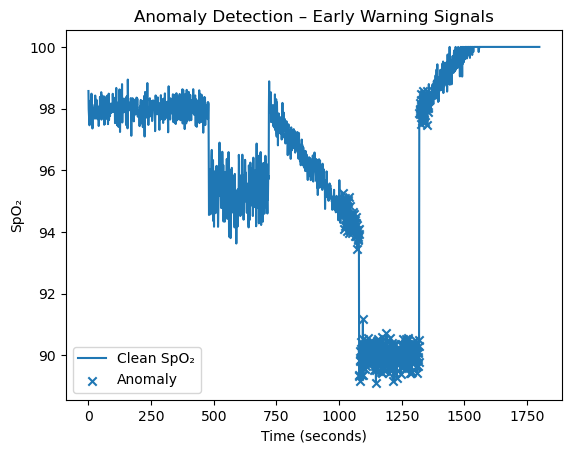

✅ Anomaly detection completed
✅ Output saved as anomaly_detection_output.csv


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. LOAD CLEANED DATA
# -------------------------------
df = pd.read_csv("synthetic_ambulance_patient_data_cleaned.csv")

# -------------------------------
# 2. ROLLING WINDOW FEATURES
# -------------------------------
WINDOW = 60  # 60 seconds

df["hr_mean"] = df["heart_rate"].rolling(WINDOW).mean()
df["spo2_mean"] = df["spo2_clean"].rolling(WINDOW).mean()
df["bp_mean"] = df["systolic_bp"].rolling(WINDOW).mean()

# -------------------------------
# 3. BASELINE (FIRST 5 MINUTES)
# -------------------------------
baseline = df.iloc[:5*60]

hr_base = baseline["hr_mean"].mean()
spo2_base = baseline["spo2_mean"].mean()
bp_base = baseline["bp_mean"].mean()

# -------------------------------
# 4. ANOMALY DETECTION LOGIC
# -------------------------------
df["anomaly"] = (
    (df["hr_mean"] > hr_base + 15) |
    (df["spo2_mean"] < spo2_base - 3) |
    (df["bp_mean"] < bp_base - 15)
)

# -------------------------------
# 5. VISUALIZATION
# -------------------------------
plt.figure()
plt.plot(df["time_sec"], df["spo2_clean"], label="Clean SpO₂")
plt.scatter(
    df.loc[df["anomaly"], "time_sec"],
    df.loc[df["anomaly"], "spo2_clean"],
    marker="x",
    label="Anomaly"
)
plt.title("Anomaly Detection – Early Warning Signals")
plt.xlabel("Time (seconds)")
plt.ylabel("SpO₂")
plt.legend()
plt.show()

# -------------------------------
# 6. SAVE RESULTS
# -------------------------------
df.to_csv("anomaly_detection_output.csv", index=False)

print("✅ Anomaly detection completed")
print("✅ Output saved as anomaly_detection_output.csv")


In [23]:
import pandas as pd
import numpy as np

# -------------------------------
# 1. LOAD ANOMALY DATA
# -------------------------------
df = pd.read_csv("anomaly_detection_output.csv")

# -------------------------------
# 2. NORMALIZE DEVIATIONS
# -------------------------------
# These are relative to baseline assumptions

df["hr_risk"] = np.clip((df["hr_mean"] - 90) / 40, 0, 1)
df["spo2_risk"] = np.clip((95 - df["spo2_mean"]) / 10, 0, 1)
df["bp_risk"] = np.clip((110 - df["bp_mean"]) / 40, 0, 1)

# -------------------------------
# 3. COMBINED RISK SCORE (0–100)
# -------------------------------
df["risk_score"] = (
    0.4 * df["hr_risk"] +
    0.4 * df["spo2_risk"] +
    0.2 * df["bp_risk"]
) * 100

# -------------------------------
# 4. CONFIDENCE SCORE
# -------------------------------
# Higher confidence if anomaly persists
df["confidence"] = df["anomaly"].rolling(120).mean()
df["confidence"] = df["confidence"].fillna(0)

# -------------------------------
# 5. ALERT LOGIC
# -------------------------------
df["alert"] = (
    (df["risk_score"] > 60) &
    (df["confidence"] > 0.6)
)

# -------------------------------
# 6. SAVE OUTPUT
# -------------------------------
df.to_csv("risk_scoring_output.csv", index=False)

print("✅ Risk scoring completed")
print("✅ Output saved as risk_scoring_output.csv")


✅ Risk scoring completed
✅ Output saved as risk_scoring_output.csv


In [24]:
import pandas as pd
import numpy as np

# -------------------------------
# 1. LOAD RISK SCORING OUTPUT
# -------------------------------
df = pd.read_csv("risk_scoring_output.csv")

# -------------------------------
# 2. DEFINE GROUND TRUTH
# -------------------------------
# Critical deterioration phase: 18–22 minutes
df["ground_truth"] = False
df.loc[
    (df["time_sec"] >= 18*60) & (df["time_sec"] <= 22*60),
    "ground_truth"
] = True

# -------------------------------
# 3. CONFUSION MATRIX
# -------------------------------
TP = ((df["alert"] == True) & (df["ground_truth"] == True)).sum()
FP = ((df["alert"] == True) & (df["ground_truth"] == False)).sum()
FN = ((df["alert"] == False) & (df["ground_truth"] == True)).sum()
TN = ((df["alert"] == False) & (df["ground_truth"] == False)).sum()

# -------------------------------
# 4. METRICS
# -------------------------------
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
false_alert_rate = FP / (FP + TN) if (FP + TN) > 0 else 0

# Alert latency
critical_start = 18 * 60
first_alert = df[(df["time_sec"] >= critical_start) & (df["alert"] == True)]

alert_latency = (
    first_alert.iloc[0]["time_sec"] - critical_star]()_


SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' on line 38 (48979612.py, line 39)

In [25]:
import pandas as pd
import numpy as np

# -------------------------------
# 1. LOAD RISK SCORING OUTPUT
# -------------------------------
df = pd.read_csv("risk_scoring_output.csv")

# -------------------------------
# 2. DEFINE GROUND TRUTH
# -------------------------------
# Critical deterioration phase: 18–22 minutes
df["ground_truth"] = False
df.loc[
    (df["time_sec"] >= 18*60) & (df["time_sec"] <= 22*60),
    "ground_truth"
] = True

# -------------------------------
# 3. CONFUSION MATRIX
# -------------------------------
TP = ((df["alert"] == True) & (df["ground_truth"] == True)).sum()
FP = ((df["alert"] == True) & (df["ground_truth"] == False)).sum()
FN = ((df["alert"] == False) & (df["ground_truth"] == True)).sum()
TN = ((df["alert"] == False) & (df["ground_truth"] == False)).sum()

# -------------------------------
# 4. METRICS
# -------------------------------
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
false_alert_rate = FP / (FP + TN) if (FP + TN) > 0 else 0

# Alert latency
critical_start = 18 * 60
first_alert = df[(df["time_sec"] >= critical_start) & (df["alert"] == True)]

alert_latency = (
    first_alert.iloc[0]["time_sec"] - critical_start
    if len(first_alert) > 0 else None
)

# -------------------------------
# 5. PRINT RESULTS
# -------------------------------
print("=== ALERT QUALITY METRICS ===")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"False Alert Rate: {false_alert_rate:.2f}")
print(f"Alert Latency (seconds): {alert_latency}")


=== ALERT QUALITY METRICS ===
Precision: 0.00
Recall: 0.00
False Alert Rate: 0.00
Alert Latency (seconds): None
